# Easy Stock and Flow modelling on cadCAD

This colab notebook shows an quick try on creating an encapsulated manner for generating stock and flow simulations on cadCAD

Authors: 
* Danilo Lessa Bernardineli (danilo.bernardineli@usp.br)
* Danilo Oliveira Vaz (put here)
* Add your name here


In [0]:
## Dependences ##
%%capture
!pip install cadcad

from collections import namedtuple
from types import SimpleNamespace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

In [0]:
## Stock / Flow classes ##

## Ignore this code block if you just want to do things

Relation = namedtuple('relation', ['src', 'dst'])
Flow = namedtuple('flow', ['name', 'src', 'dst', 'function', 'policy'])

class Stock():
  """
  Stock representing an cadCAD variable / state update function
  """
  count = 0

  def __init__(self, name: str, n: float):
    self.name = name
    self.count = n


  def __lshift__(self, other: object):
    return Relation(other, self)


  def __rshift__(self, other: object):
    return Relation(self, other)

  def __repr__(self):
    return "Stock(name={}, count={})".format(self.name, self.count)
    

class Nowhere(Stock):
  """
  Stock for allowing flows from nowhere.
  """
  count = None
  name = "nowhere"
  def __init__(self):
    pass
        

class System:
  """
  Container for the stocks and flows. Represents an cadCAD configuration.
  """
  nowhere = None
  stocks = []
  flows = []
    
  def __init__(self):
    self.nowhere = Nowhere()
    
    
  def add_stock(self, name: str, n: float):
    """
    Add a stock on the system instance.
    """
    stock = Stock(name, n)
    self.stocks.append(stock)
    return stock


  def gen_flow_policy(self, relation: Relation, function: callable):
    """
    Generates an cadCAD policy based on the flow and associated stocks.
    """
    def new_function(params, step, sL, s):
      y = function(s[relation.src.name], s[relation.dst.name], params[0], s)
      return {relation.dst.name: y,
              relation.src.name: -y}
    return new_function


  def add_flow(self, name: str, relation: Relation, function: callable=None):
    """
    Creates an flow in the system. Uses an sum relation by default.
    """
    if function is None:
      function = lambda src, dst: src + dst
    policy = self.gen_flow_policy(relation, function)
    flow = Flow(name, *relation, function, policy)
    self.flows.append(flow)
        
        
  def gen_state_update(self, variable_name: str):
    """
    Creates an generic cadCAD state update function.
    """
    def new_function(params, step, sL, s, _input):
      y = variable_name
      x = s[y]
      x += _input.get(y, 0)
      return (y, x)
    return new_function
            

  def generate_config(self, initial_state: dict={}, sim_config: dict={}, **kwargs):
    """
    Generates an cadCAD configuration dictionary based on the system instance.
    """
    variables = {}
    state_update = {}
    variables['nowhere'] = np.inf

    # Create variables and partial state update blocks
    for stock in self.stocks:
      variables[stock.name] = stock.count
      state_update[stock.name] = self.gen_state_update(stock.name)
    state_update['nowhere'] = lambda params, step, sL, s, _input: ('nowhere', np.inf)

    # Create policy update blocks
    policies = {}
    for flow in self.flows:
      policies[flow.name] = flow.policy
      partial_state_update_blocks = [{"policies": policies,
                                      "variables": state_update
                                      }]
    # The configuration dict
    config = Configuration(initial_state=variables,
                             partial_state_update_blocks=partial_state_update_blocks,
                             sim_config=sim_config)
    return config

    
  def run(self, T: int=100, N: int=1, params: dict={}):
    """
    Simulate the system instance on cadCAD on single proc mode.
    """
    sim_config = {'T': range(T),
                  'N': N,
                  'M': params}
    config = self.generate_config(sim_config=sim_config)
    exec_mode = ExecutionMode()
    exec_context = ExecutionContext(exec_mode.single_proc)
    executor = Executor(exec_context, [config]) 
    raw_result, tensor = executor.execute() 
    return raw_result


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7ff001327080>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7ff001327080>]


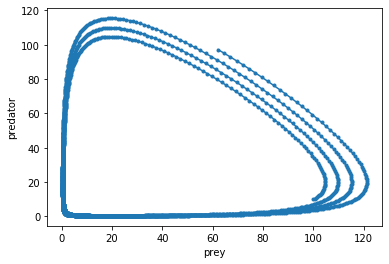

In [0]:
## The actual stock and flow modelling code block ##

# System
s = System()
nowhere = s.nowhere

# Stocks
prey = s.add_stock('prey', 100)
predator = s.add_stock('predator', 10)

# Parameters
dt = 0.01
params = {'prey_birth_rate': 1.0 * dt,
          'predator_birth_rate': 0.0 * dt,
          'prey_death_rate': 0.03 * dt,
          'predator_death_rate': 1.0 * dt,
          'prey_predator_interaction': 0.05 * dt}

# Flows
s.add_flow('1', nowhere >> prey, lambda src, dst, params, s: dst * params['prey_birth_rate'])
s.add_flow('2', nowhere >> predator, lambda src, dst, params, s: dst * params['predator_birth_rate'])
s.add_flow('3', predator >> nowhere, lambda src, dst, params, s: src * params['predator_death_rate'])
s.add_flow('4', prey >> nowhere, lambda src, dst, params, s: src * params['prey_death_rate'])
s.add_flow('5', prey >> predator, lambda src, dst, params, s: src * dst * params['prey_predator_interaction'])

# Simulation
raw_results = pd.DataFrame(s.run(T=3000, params=params))
results = raw_results
plt.xlabel("prey")
plt.ylabel("predator")
plt.plot(results.prey, results.predator, '.-')
plt.show()

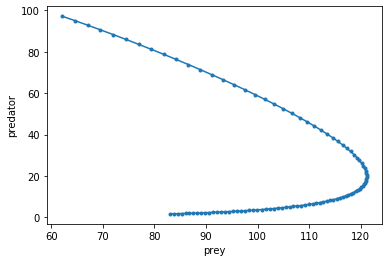

In [0]:
results = raw_results[-100:]
plt.xlabel("prey")
plt.ylabel("predator")
plt.plot(results.prey, results.predator, '.-')
plt.show()

In [0]:
lista = [1, 2, 5, -1]

dicionario = {"a": 5, "b": 9}


for nome, valor in dicionario.items():
  print("{}\t{:.5f}".format(nome, valor))

a	5.00000
b	9.00000


In [0]:
parametros = {"valor_1": 10,
              "valor_2": 15}

print("{valor_1}: {valor_2}".format(**parametros))

10: 15


In [0]:
"".join([t.replace("q", " -") for t in "qwert  yuiop".split(" ")])

' -wertyuiop'

In [0]:
sujo = " asdasdqwdqwcwq q d wq    qw q    " 
limpo = (sujo.replace("a", "")
             .replace("q", "-")
          #   .replace("b", "c")
             .strip()[::2])
print(limpo)

ss-dww   -  w-


In [0]:
limpo

'ssqdww   q  wq'

In [0]:
raw_results

,nowhere,prey,predator,run,substep,timestep
0,inf,100.000000,10.000000,1,0,0
1,inf,100.470000,10.400000,1,1,1
2,inf,100.922115,10.818444,1,1,2
3,inf,101.355149,11.256170,1,1,3
4,inf,101.767859,11.714043,1,1,4
...,...,...,...,...,...,...
81996,inf,NaN,NaN,1,1,81996
81997,inf,NaN,NaN,1,1,81997
81998,inf,NaN,NaN,1,1,81998
81999,inf,NaN,NaN,1,1,81999


In [0]:
nowhere >> predator

relation(src=Stock(name=nowhere, count=None), dst=Stock(name=predator, count=10))